In [10]:
import cv2
import numpy as np
from utils import Kinect
import matplotlib.pyplot as plt
import time

In [3]:
kinect = Kinect(light_model=False)

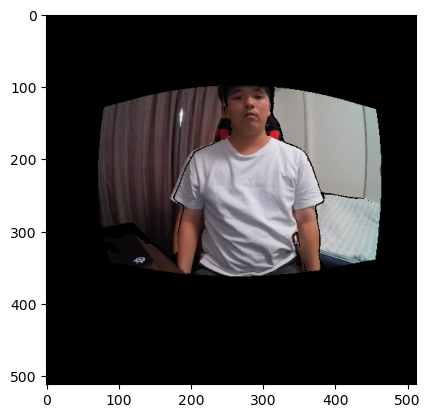

In [13]:
time.sleep(3)
kinect.update()
(neck, pelvis, left_shoulder, right_shoulder) = kinect.joints
depth_img_org = kinect.depth_img
mask_img_org = kinect.mask_img
_, color_image_org = kinect.capture.get_transformed_color_image()
color_image_org = cv2.cvtColor(color_image_org, cv2.COLOR_RGBA2BGR)
depth_img, mask_img, color_image = depth_img_org.copy(), mask_img_org.copy(), color_image_org.copy()

plt.imshow(color_image)

In [4]:
#
print(color_image.shape)

(512, 512, 3)


[279 183]


True

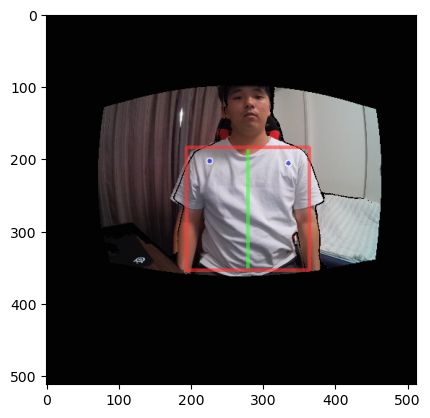

In [49]:
depth_img, mask_img, color_image = depth_img_org.copy(), mask_img_org.copy(), color_image_org.copy()
#クロッピング
h, w = depth_img.shape
vertical_spine = int( max(abs(neck[0] - pelvis[0]), abs(neck[1] - pelvis[1])) / 2 )
center_spine = (neck + pelvis) // 2
left_top = (center_spine - vertical_spine).astype(np.uint16)
right_bottom = (center_spine + vertical_spine).astype(np.uint16)

print(neck.astype(np.uint16))
cv2.line(color_image, neck.astype(np.uint16), pelvis.astype(np.uint16), (50, 255, 50), 4)
cv2.rectangle(color_image, left_top, right_bottom, (255, 50, 50), 4)
cv2.circle(color_image, center=left_shoulder.astype(np.uint16), radius=5, color=(255,255,255), thickness=-1)
cv2.circle(color_image, center=left_shoulder.astype(np.uint16), radius=3, color=(0,0,255), thickness=-1)
cv2.circle(color_image, center=right_shoulder.astype(np.uint16), radius=5, color=(255,255,255), thickness=-1)
cv2.circle(color_image, center=right_shoulder.astype(np.uint16), radius=3, color=(0,0,255), thickness=-1)
result_color = cv2.addWeighted(color_image, 0.6, color_image_org, 0.4, 2.2)
plt.imshow(result_color)

top = 2000
bot = 250
depth_shifted = np.clip(depth_img-bot, 0, top-bot)/(top-bot)*256
depth_shifted[depth_shifted>255] = 0
depth_shifted = depth_shifted.astype(np.uint8)
cmap = plt.get_cmap("viridis")
depth_proccessed = cv2.cvtColor(cmap(depth_shifted, bytes=True), cv2.COLOR_RGBA2BGR)
depth_temp = depth_proccessed.copy()


cv2.line(depth_proccessed, neck.astype(np.uint16), pelvis.astype(np.uint16), (50, 255, 50), 4)
cv2.rectangle(depth_proccessed, left_top, right_bottom, (50, 50, 255), 4)
cv2.circle(depth_proccessed, center=left_shoulder.astype(np.uint16), radius=5, color=(255,255,255), thickness=-1)
cv2.circle(depth_proccessed, center=left_shoulder.astype(np.uint16), radius=3, color=(255,0,0), thickness=-1)
cv2.circle(depth_proccessed, center=right_shoulder.astype(np.uint16), radius=5, color=(255,255,255), thickness=-1)
cv2.circle(depth_proccessed, center=right_shoulder.astype(np.uint16), radius=3, color=(255,0,0), thickness=-1)


result_depth = cv2.addWeighted(depth_proccessed, 0.6, depth_temp, 0.4, 2.2)


cropped_depth = depth_img[
  max(0, left_top[1]): min(w, right_bottom[1]),
  max(0, left_top[0]): min(h, right_bottom[0]),
]

cropped_depth_masked = mask_img[
  max(0, left_top[1]): min(w, right_bottom[1]),
  max(0, left_top[0]): min(h, right_bottom[0]),
]

cv2.imwrite("graphs/frame_depth2.jpg", result_depth)
cv2.imwrite("graphs/frame_color2.jpg", cv2.cvtColor(result_color, cv2.COLOR_BGR2RGB))

0 1850
0 1


True

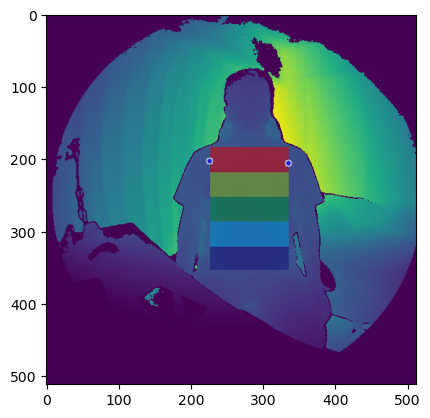

In [52]:
#領域分割
COLORS = [
  [199, 9, 11],
  [123, 170, 23],
  [0, 135, 60],
  [0, 141, 203],
  [24, 24, 120]
]
N = 5

cropped_neck, cropped_pelvis = neck - left_top, pelvis - left_top
cropped_left_shoulder, cropped_right_shoulder = (
  left_shoulder - left_top,
  right_shoulder - left_top,
)
spine_vec = cropped_neck - cropped_pelvis
slope = spine_vec[1] / spine_vec[0]
x_line = np.arange(cropped_depth.shape[0])
y_line = np.arange(cropped_depth.shape[1])
x_grid, y_grid = np.meshgrid(x_line, y_line)

h_cropped, w_cropped  = cropped_depth.shape

# 領域分割用の１次関数
gradation_split = x_grid + slope * y_grid
split_pos = np.stack(
  (
    np.linspace(cropped_neck[0], cropped_pelvis[0], N + 1),
    np.linspace(cropped_neck[1], cropped_pelvis[1], N + 1),
  ),
  1,
)

print(cropped_depth.min(),cropped_depth.max())
separate_color = np.full((h_cropped, w_cropped, 3), 0, dtype=np.uint8)
for i in range(N):
  border_upeer, border_lower = split_pos[i], split_pos[i+1]
  
  threshold_upeer = border_upeer[0] + \
    border_upeer[1] * slope
  threshold_lower = border_lower[0] + \
    border_lower[1] * slope
  
  separate_color[(((gradation_split > threshold_upeer)
    ^ (gradation_split > threshold_lower)))
    & cropped_depth_masked > 0] = COLORS[i]
  
print(cropped_depth_masked.min(), cropped_depth_masked.max())

#==========================
# 重み付け用の１次関数（軸からの距離）
gradation_distance = (
  y_grid - cropped_neck[1]) - (x_grid - cropped_neck[0]) * slope

# 1時間数に沿った肩幅位置
distance_right_shoulder = (cropped_right_shoulder[1] - cropped_neck[1]) - slope * (
  cropped_right_shoulder[0] - cropped_neck[0]
)
distance_left_shoulder = (cropped_left_shoulder[1] - cropped_neck[1]) - slope * (
  cropped_left_shoulder[0] - cropped_neck[0]
)

depth_torso = np.where(
  (
    (gradation_distance > distance_right_shoulder)
    & (gradation_distance < distance_left_shoulder)
    | (gradation_distance < distance_right_shoulder)
    & (gradation_distance > distance_left_shoulder)
  ),
  cropped_depth_masked,
  0,
)

coloring_mask = np.zeros((h,w), dtype=np.uint8)
coloring_mask [
  max(0, left_top[1]): min(w, right_bottom[1]),
  max(0, left_top[0]): min(h, right_bottom[0])
                                    ] = depth_torso

extended_separate_color = np.zeros((h,w,3), dtype=np.uint8)
extended_separate_color[
  max(0, left_top[1]): min(w, right_bottom[1]),
  max(0, left_top[0]): min(h, right_bottom[0])
                                    ] = separate_color

coloring_mask = np.stack([coloring_mask]*3, -1)
img_separated_colored = np.where(coloring_mask>0, extended_separate_color, color_image_org)
cv2.circle(img_separated_colored, center=left_shoulder.astype(np.uint16), radius=5, color=(255,255,255), thickness=-1)
cv2.circle(img_separated_colored, center=left_shoulder.astype(np.uint16), radius=3, color=(0,0,255), thickness=-1)
cv2.circle(img_separated_colored, center=right_shoulder.astype(np.uint16), radius=5, color=(255,255,255), thickness=-1)
cv2.circle(img_separated_colored, center=right_shoulder.astype(np.uint16), radius=3, color=(0,0,255), thickness=-1)
img_separated_colored = cv2.addWeighted(color_image_org, 0.4, img_separated_colored, 0.6, 1)


depth_proccessed = cv2.cvtColor(cmap(depth_shifted, bytes=True), cv2.COLOR_RGBA2RGB)
img_separated_depth = np.where(coloring_mask>0, extended_separate_color, depth_proccessed)
cv2.circle(img_separated_depth, center=left_shoulder.astype(np.uint16), radius=5, color=(255,255,255), thickness=-1)
cv2.circle(img_separated_depth, center=left_shoulder.astype(np.uint16), radius=3, color=(0,0,255), thickness=-1)
cv2.circle(img_separated_depth, center=right_shoulder.astype(np.uint16), radius=5, color=(255,255,255), thickness=-1)
cv2.circle(img_separated_depth, center=right_shoulder.astype(np.uint16), radius=3, color=(0,0,255), thickness=-1)
img_separated_depth = cv2.addWeighted(depth_proccessed, 0.4, img_separated_depth, 0.6, 1)

plt.imshow(img_separated_depth)

cv2.imwrite("graphs/area_color2.jpg", cv2.cvtColor(img_separated_colored, cv2.COLOR_BGR2RGB))
cv2.imwrite("graphs/area_depth2.jpg", cv2.cvtColor(img_separated_depth, cv2.COLOR_BGR2RGB))

In [89]:
cropped_depth2save = cropped_depth.copy()

area_cropped = cropped_depth2save[(500<cropped_depth2save) & (cropped_depth2save<800)]
cropped_depth2save = np.where(500<cropped_depth2save, cropped_depth2save, area_cropped.min())
cropped_depth2save = np.where(cropped_depth2save<800, cropped_depth2save, area_cropped.max())

cropped_depth2save = (255*(cropped_depth2save - cropped_depth2save.min())/(cropped_depth2save.max() - cropped_depth2save.min())).astype(np.uint8)
cropped_depth_view = cv2.cvtColor(plt.get_cmap("grey")(cropped_depth2save, bytes=True), cv2.COLOR_RGBA2RGB)
cv2.imwrite("graphs/cropped_depth.jpg", cropped_depth_view)

True